# CM30320 Coursework

## Task & Data Analysis

We can see that our data is divided into numerous text files; it is a subset of the entire Movie Review Dataset that includes 2,000 positive and 2,000 negative movie reviews. The names of the text files containing the reviews' text content are their respective review ids and ratings. The reviews are then extracted by taking into account these text files and the directories they are located in. 

Given the star rating, we could extract that information. The data is divided into positive and negative based on a threshold of the rating. To simplify the task, the model here does not take into consideration the rating and we rely on only the postive/negative class. This leads to the conclusion that this problem would be a binary classification task.

We start the implementation by importing the relevant modules for this task. We consider the python libraries specialised for NLP tasks: nltk, spacy, re, and string. Furthermore, we also import the models that we would used for this classification task: Naive Bayes. We later look into various methods, in this module, that contain important functions for syntatic ananlysis, and also the different databases for the aforementioned functions.

In [41]:
import nltk, re, os, string
import numpy as np
import pandas as pd
import spacy
import scipy
import matplotlib.pyplot as plt
import wordcloud
import tensorflow as tf
import keras
from textblob import Word
from google.colab import drive
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import manifold, metrics
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras import callbacks

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-processing the Data

These are methods to do morphological analysis, where we find the base form of the word; it is done to reduce computational complexity and also make sure relevant information is not lost.

**Lemmatization** algorithms work based on a dictionary of base forms. They first check the part of speech tag of the word to find out the base form and this is the reason why the nltk lemmatizer requires the pos tag as a parameter (spacy's lemmatizer does not require this). This method is more resource intensive but provides us with more human readable data.

Part of Speech tagging is the process of classifying words in a text according to a specific part of speech based on the word's definition and context. The typical structure of lexical phrases within a sentence or text is described by part-of-speech tags, so we may use them to infer semantics.

**Stemmming** on the other hand resorts to the cutting of word at a specific length. It does not use part of speech tags and does not lead to human readable data. However, it is more efficient and can be used if we want our algorithm to compute quicker.

**Tokenisation** is the first pre processing step that we do. Machines get words as sequences of symbols and have no idea what it means. Tokenization or word segmentation is the task of seperating out words in raw text.

It needs to be applied before other tools are applied, it has to run fast and be accurate. We do not create our own tokenizer here and rather use nltk's tokenizer which effectively gives us words as tokens in a list. We use this in tandem with our stemming or lemmatization algorithms.

Furthermore, before performing tokenisation, we ensure that we clean our text; we remove the brackets, the irrelavant punctuation and also HTML tags. We do the following using regex patterns and the string library provided by python.

In [3]:
## globals
reviews = []
sentiments = []

def clean_text(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub('\[[^]]*\]', '', text)
  text = re.sub(pattern, '', text)
  return text

def get_wordnet_pos(word:str):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def process_stem(text:str) -> list:
  stoplist = set(stopwords.words('english') + ['movie', 'film'])
  st = LancasterStemmer()
  text_temp = text
  text_temp = clean_text(text)
  word_list = [st.stem(word) for word in word_tokenize(text_temp.lower()) if not word in stoplist 
               and not word in string.punctuation]
  return word_list

def process_lemm(text:str) -> list:
  stoplist = set(stopwords.words('english') + ['movie', 'film'] )
  lemmatizer =  WordNetLemmatizer()
  text_temp = text
  text_temp = clean_text(text)
  word_list = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(text_temp.lower()) if not word in stoplist 
               and not word in string.punctuation]
  return word_list

def get_reviews(review_type:str) -> list:
  reviews_list = []
  for file in listdir(f"/content/drive/MyDrive/Colab Notebooks/CM30320/Data/{review_type}"):
    with open(f"/content/drive/MyDrive/Colab Notebooks/CM30320/Data/{review_type}/{file}",'r') as review:
      reviews_list.append(review.read().replace("<br />"," "))
  return reviews_list

def get_sentiment(review_type:str) -> list:
  if review_type == "pos":
    return [0] * 2000
  elif review_type == "neg":
    return[1] * 2000

def detokenize(reviews):
  detokenized_doc = []
  for i in range(len(reviews)):
    t = ' '.join(reviews[i])
  detokenized_doc.append(t)
  return detokenized_doc

### Initial Data Acquistion Approach

We begin by creating two global list variables; reviews and sentiments. We acquire the data from the text files by iterating through them based on their folder. The text is then cleaned initially from the `<br />` tag as it is difficult to remove alone using regex. We add the positive reviews and negative reviews into a single reviews list. 

Since, we know that the first 2000 reviews are positive and the next 2000 reviews are negative, we create the sentiment list quite easily. This sentiment list is used as our label. 

After the following we create the `cleaned_text`, `lemmatized_reviews`, and `stemmed_reviews` lists using the raw data of `reviews` list. After getting the following we create our dataframe holding our data together.

In [4]:
reviews = get_reviews("pos") + get_reviews("neg")
sentiment = get_sentiment("pos") + get_sentiment("neg")

In [5]:
lemmatized_reviews = list(map(process_lemm, reviews))
stemmed_reviews = list(map(process_stem, reviews))
cleaned_text = list(map(clean_text, reviews))

In [6]:
df = pd.DataFrame({
    "Reviews": reviews,
    "Lemmatized": lemmatized_reviews,
    "Stemmed" : stemmed_reviews,
    "Cleaned": cleaned_text,
    "Sentiment" : sentiment
})

# label_encoder = LabelEncoder()
# df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

df.head()

,Reviews,Lemmatized,Stemmed,Cleaned,Sentiment
0,"In some ways, The Wrath of Kriemhild surpasses...","[way, wrath, kriemhild, surpasses, siegfried, ...","[way, wra, kriemhild, surpass, siegfry, dea, a...",In some ways The Wrath of Kriemhild surpasses ...,0
1,I've seen the original English version on vide...,"[ive, see, original, english, version, video, ...","[iv, seen, origin, engl, vert, video, disney, ...",Ive seen the original English version on video...,0
2,"Hello, I was alanrickmaniac. I'm a Still Crazy...","[hello, alanrickmaniac, im, still, crazyholic,...","[hello, alanrickmaniac, im, stil, crazyhol, an...",Hello I was alanrickmaniac Im a Still Crazyhol...,0
3,I did not like Chandni Bar from the same direc...,"[like, chandni, bar, director, watch, movie, c...","[lik, chandn, bar, direct, watch, movy, cam, w...",I did not like Chandni Bar from the same direc...,0
4,"""A Mouse in the House"" is a very classic carto...","[mouse, house, classic, cartoon, tom, jerry, f...","[mous, hous, class, cartoon, tom, jerry, faith...",A Mouse in the House is a very classic cartoon...,0


### Cummulative frequency of words and its effects
Here we built a chart to see the cummulative counts of word increase based on 
their occurences. We look at the frequency of the lemmatized text. As the text has been cleared of stopwords, we see that the cummulative frequency does not saturate as soon. 

However, we the effects of the stopwords in the graph below. These words help 'glue' the information together but do not offer much on their own. Therefore, we consider removing them as part of feature selection. This would help us in finding the best features for our model and also allow us to reduce training time. 

We do this step during our lemmatization/stemming process in the list comprehension we make, as you can see from the functions defined above. If the word is in the stoplist (which we gather from the nltk word corpus; we get the stopwords), we do not add the word to the list.

Furthermore, consideration is taken to remove words; 'movie' and 'film' as we know that we are talking about movies or films here, and also they were occuring quite often in the corpus not providing us with further information.

[('one', 4484), ('make', 3781), ('like', 3570), ('see', 3286), ('get', 2894), ('time', 2425), ('well', 2424), ('good', 2359), ('character', 2349), ('go', 2308), ('story', 2252), ('watch', 2093), ('even', 2088), ('would', 2008), ('bad', 1991), ('really', 1887), ('scene', 1791), ('show', 1681), ('great', 1665), ('much', 1658), ('also', 1629), ('end', 1605), ('look', 1597), ('film', 1531), ('say', 1529), ('people', 1480), ('first', 1476), ('give', 1476), ('way', 1438), ('love', 1380), ('thing', 1352), ('come', 1352), ('know', 1346), ('think', 1340), ('dont', 1333), ('take', 1321), ('act', 1319), ('life', 1297), ('could', 1295), ('seem', 1273), ('movie', 1254), ('work', 1180), ('two', 1162), ('want', 1132), ('little', 1113), ('plot', 1100), ('actor', 1073), ('try', 1068), ('many', 1068), ('never', 1057)]


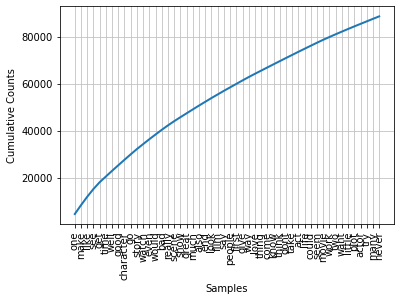

In [7]:
def feq_50words(df_column):
  corpus = df_column.values.tolist()
  corpus = [word for sentence in corpus for word in sentence]
  frequency = nltk.FreqDist(corpus)
  return frequency

frequency = feq_50words(df['Lemmatized'])
print(frequency.most_common(50))
frequency.plot(50, cumulative=True)

[('the', 48132), (',', 45251), ('.', 44739), ('a', 26499), ('and', 25869), ('of', 23776), ('to', 22377), ('is', 18263), ('in', 14745), ('I', 13056), ('it', 12492), ('that', 11750), ("'s", 10638), ('this', 9786), ('was', 7993), ('as', 7405), ('The', 7276), ('with', 7258), ('for', 7066), ('movie', 6686), ('film', 6526), (')', 6204), ('(', 6097), ('but', 5960), ('``', 5522), ("''", 5501), ("n't", 5425), ('on', 5235), ('are', 5084), ('his', 4843), ('not', 4823), ('you', 4787), ('have', 4564), ('he', 4324), ('be', 4248), ('one', 3949), ('by', 3660), ('at', 3556), ('an', 3508), ('who', 3489), ('all', 3429), ('from', 3300), ('!', 3256), ('they', 3186), ('her', 3113), ('like', 3112), ('It', 2964), ('so', 2853), ('about', 2850), ('has', 2782)]


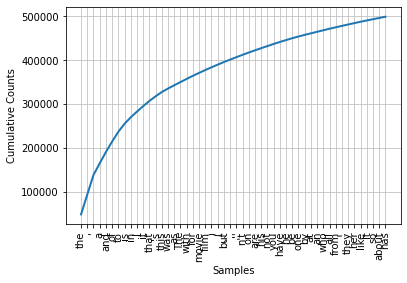

In [8]:
reviews_token_df = pd.DataFrame({
    'tokens' : list(map(word_tokenize, df['Reviews'])) 
})
frequency = feq_50words(reviews_token_df['tokens'])
print(frequency.most_common(50))
frequency.plot(50, cumulative=True)

### Visualising most common words through word cloud
To understand the whole corpus better, a word cloud is created to check which words are worth considering and which are not. The size of the word represents the frequency of the occurence.There are still some words which are irrelvant to our model but individually removing them all would be difficult. There is also a possibility that their relationships could prove beneficial.

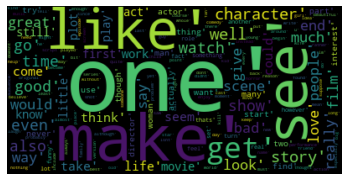

In [9]:
most_common_words=''
for text in df.Lemmatized:
  text = str(text)
  tokens = text.split()
  most_common_words += " ".join(tokens) + " "
cloud = wordcloud.WordCloud().generate(most_common_words)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

## Creating a Baseline Model

To start, we build a model without any of the NLP tasks that would be useful for our sentiment analysis model. The model in this case accepts vectors that represent the word counts in the document. We vectorise the word input and obtain a sparse matrix, which we then supply to the model. But first, we must separate the data.

We must input the counts and sentiments in order to separate the data. Additionally, this data must first be mixed up and divided into training and test sets. We perform a Stratified Shuffle Split using Scikit-Learn in order to achieve this.

The data is evenly split into training and testing data thanks to a stratified shuffle split (70:30 split). This guarantees that data is evenly sampled from each class, unlike a random split. We'll utilise it once again for our primary model as well, which you'll see later. We then fit the model to the data after collecting it.

The naïve bayes model performs admirably on its own, with an accuracy of 80.75% when given test data. Decision trees perform the poorest, which is sense given the vastness of the data because a too-deep tree would be useless. But as we can see, logistic regression works the best in this case. For this experiment, we will seet the naive bayes model as the baseline and build on top of that as well create our own neural network to work that uses LSTM for this task. Therefore, with the upcoming set of actions and models, we will attempt to improve this score even though we are still primarily concerned with naive bayes model.

In [57]:
def baseline_model(model, x_train, x_test, y_train, y_test):

    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100}")
    print(f"Recall: {metrics.recall_score(y_test, naive_classifier_pred, average=None) * 100}")
    print(f"Precision: {metrics.precision_score(y_test, naive_classifier_pred, average=None) * 100}")
    return None


In [54]:
cow = CountVectorizer()
count = cow.fit_transform(df['Reviews'])

In [55]:
def shuffleSplit(data):
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
  split.get_n_splits(data, df['Sentiment'])
  print(split)      
  for train_index, test_index in split.split(data, df['Sentiment']):
      print("TRAIN:", len(train_index), "TEST:", len(test_index))
      X_train, X_test = data[train_index], data[test_index]
      y_train, y_test = df['Sentiment'][train_index], df['Sentiment'][test_index]
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = shuffleSplit(count)

print("\nThe data is as follows: ",X_train.shape, y_train.shape, X_test.shape, y_test.shape)


StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=None)
TRAIN: 2800 TEST: 1200

The data is as follows:  (2800, 35666) (2800,) (1200, 35666) (1200,)


In [58]:
print("Naive bayes: ")
baseline_model(MultinomialNB(), X_train, X_test, y_train, y_test)

print("\nDecision trees: ")
baseline_model(DecisionTreeClassifier(max_depth=10, random_state=0), X_train, X_test, y_train, y_test)

print("\nLogistic regression: ")
baseline_model(LogisticRegression(max_iter=20), X_train, X_test, y_train, y_test)

Naive bayes: 
Accuracy: 80.75
Recall: [43.5        59.83333333]
Precision: [51.99203187 51.43266476]

Decision trees: 
Accuracy: 71.41666666666666
Recall: [43.5        59.83333333]
Precision: [51.99203187 51.43266476]

Logistic regression: 
Accuracy: 83.41666666666666
Recall: [43.5        59.83333333]
Precision: [51.99203187 51.43266476]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Creating a Basic LSTM for Sentiment Analysis
A particular kind of supervised deep learning technique is recurrent neural networks. Over time, the neurons become interconnected with one another. RNNs are designed to recall the data that was present in earlier neurons so that these neurons can transmit data to themselves in the future for additional processing. The vanishing gradient, however, is one of the issues with RNN. We transmit the weights to these neurons throughout time. The weights from earlier in the network must be multiplied back through the gradient calculated at each time step. As a result, the gradient weakens and disappears as we move further back in time to calculate the weights in the network.

To solve the vanishing gradient issue, RNN was upgraded to include LSTM. It features a memory cell at the top that makes it easier to efficiently transfer information from one point in time to the next. In contrast to RNN, it can therefore recall a great deal of data from earlier states and solve the vanishing gradient issue.

Here, we use the LSTM layer from the keras libray in our model with the required layers for the model and we also use spatial dropout to promote independence between feature maps. On top of that we use the adam optimiser with a learnig rate to make sure we are efficient with our training. While training we employ eary stopping to ensure the model does not overfit to the data and remains generalised.

References
- https://www.analyticsvidhya.com/blog/2021/06/natural-language-processing-sentiment-analysis-using-lstm/
- https://keras.io/api/layers/regularization_layers/spatial_dropout1d/#:~:text=SpatialDropout1D%20class&text=Spatial%201D%20version%20of%20Dropout,maps%20instead%20of%20individual%20elements.

Here we tokenize the words using the tokenizer from keras. The tokenizer has two hyper parameters, one checks how many words to keep based on the frequency of words. The split refers to the delimeter used for splitting the text.
Then we convert the sequence the sequence of text into a numpy array.

In [25]:
tokenizer = Tokenizer(num_words=300, split=' ')
tokenizer.fit_on_texts([' '.join(text) + ' ' for text in df['Lemmatized']])
X = tokenizer.texts_to_sequences([' '.join(text) + ' ' for text in df['Lemmatized']])
X = pad_sequences(X)

We use `tf.backend.clear_session` to ensure that there are no pre-existing model history before we start the model preparation. The model summary can be seen below through the function `model.summary()`. We then get the label values, and then split our training and testing data for training.

In [26]:
tf.keras.backend.clear_session

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-2,
                decay_steps=10000,
                decay_rate=0.9)

model = Sequential()
model.add(Embedding(300, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 370, 120)          36000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 370, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 245,442
Trainable params: 245,442
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
y=pd.get_dummies(df['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, train_size=0.7, random_state = 42)

In [29]:
batch_size=16

# Using Early Stopping to determine optimal epochs
earlystopping = callbacks.EarlyStopping(monitor ="accuracy", 
                                        mode ="max", patience = 3, 
                                        restore_best_weights = True)

history = model.fit(X_train, y_train, 
                    epochs = 10, 
                    batch_size=batch_size,
                    callbacks=earlystopping, 
                    verbose = 'auto')

Epoch 1/10
175/175 [==============================] - 111s 637ms/step - loss: 0.4043 - accuracy: 0.8171
Epoch 2/10
175/175 [==============================] - 113s 647ms/step - loss: 0.3760 - accuracy: 0.8300
Epoch 3/10
175/175 [==============================] - 115s 658ms/step - loss: 0.3665 - accuracy: 0.8368
Epoch 4/10
175/175 [==============================] - 114s 651ms/step - loss: 0.3599 - accuracy: 0.8421
Epoch 5/10
175/175 [==============================] - 135s 770ms/step - loss: 0.3820 - accuracy: 0.8289
Epoch 6/10
175/175 [==============================] - 135s 770ms/step - loss: 0.3748 - accuracy: 0.8346
Epoch 7/10
175/175 [==============================] - 123s 705ms/step - loss: 0.3641 - accuracy: 0.8436
Epoch 8/10
175/175 [==============================] - 135s 771ms/step - loss: 0.3594 - accuracy: 0.8421
Epoch 9/10
175/175 [==============================] - 114s 650ms/step - loss: 0.3580 - accuracy: 0.8400
Epoch 10/10
175/175 [==============================] - 118s 672m

## Creating a Multi Nomial Naive Bayes Classifier using TF-IDF

We use TF-IDF vectorizer here to provide meaningful number representation to our texts. The TF-IDF vectorizer considers overall documents of weight of words. We basically create a vector space where each term of vector is indexed as our index vocabulary. The TF-IDF vectorizer looks at the frequency of occurence of word in the document with frequency of word in the entire corpus. Additionally it also normalises the data as well.

We do not tune the hypereparameters, min_df and max_df in the TF-IDF vectoriser as we already remove a lot of the stopwords from the corpus using nltk's stop word list and some of our own additions. It might be believed that letting terms that occur often would reduce the quality of TF-IDF but this not the case as the formula accounts for reducing the weightage of such terms. Therefore, pruning terms based on `min_df` and `max_df` is for improving performance and would not be useful here. (https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer)

We use the `ngram_range` to perform a chunking of sorts. It sets up the word tokens to consider a single word or a pair of words together. For example, `['he will', 'today, 'great weather']`. This helps us improve our feature space and creates relational mapping with words to better weight them.

Furthermore, the data we provide to the algorithm here is lemmatized, cleaned and has the stop words removed along with additional words to our liking.

In [30]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1,2))
vector = tfidf.fit_transform([' '.join(text) + ' ' for text in df['Lemmatized']])
vector_stem = tfidf.fit_transform([' '.join(text) + ' ' for text in df['Stemmed']])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(vector, df['Sentiment'], test_size = 0.3, train_size=0.7, random_state = 42)

In [32]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train,y_train)
naive_classifier_pred = naive_classifier.predict(X_test)

## Models evaluation

We decide to evaluate our model by checking the accuracy, precision and recall and we look for changes in these values from the model before.

In [33]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train,y_train)
naive_classifier_pred = naive_classifier.predict(X_test)
print(f"Accuracy of Naive Bayes using TF-IDF: {metrics.accuracy_score(y_test, naive_classifier_pred) * 100}")
print(f"Recall of Naive Bayes using TF-IDF: {metrics.recall_score(y_test, naive_classifier_pred, average=None) * 100}")
print(f"Precision of Naive Bayes using TF-IDF: {metrics.precision_score(y_test, naive_classifier_pred, average=None) * 100}")

Accuracy of Naive Bayes using TF-IDF: 83.0
Recall of Naive Bayes using TF-IDF: [73.95498392 92.73356401]
Precision of Naive Bayes using TF-IDF: [91.63346614 76.79083095]


### The Recieving Operating Characteristic of Naive Bayes & Confusion Matrix

The ROC curve here shows the sensitivity the classifier at the expense of fall out. The classifier is better the more the curve goes towards the upper left corner. Here we see that the classifier has primarily made good classifications above the diagonal line. Another metric is the area under the curve, a good classifier would have a score of 1. This classifier has a very good score of 91.8%. However, we see from the confusion matrix that it has issues with positive ratings and identifies a lot of the reviews as False Positives.

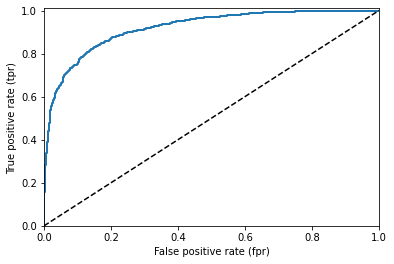

In [44]:
y_probas = cross_val_predict(naive_classifier, X_train, y_train, cv=3, method="predict_proba")
y_scores = y_probas[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    
plot_roc_curve(fpr, tpr, "Multinomial Naive Bayes")
plt.show()

In [50]:
y_scores_cm = cross_val_predict(naive_classifier, X_train, y_train, cv=5)
print("The AUC score of the following naive bayes classifier with TF-IDF:", metrics.roc_auc_score(y_train, y_scores))
print("The confusion matrix of the following naive bayes classifier: \n", metrics.confusion_matrix(y_train, y_scores_cm))

The AUC score of the following naive bayes classifier with TF-IDF: 0.9189432492513457
The confusion matrix of the following naive bayes classifier: 
 [[ 975  403]
 [ 118 1304]]


### Evaluating the Neural Network
Overall the neural network does not perform particularly better than the models we had proposed before. There is very little increase the accuracy of the model when testing. Furthermore, the time consumption to train the model is also not beneficial for developmental practices. 

However, the model has not been tuned and trained for large epochs. Given that the model only has ~250,000 parameters and is trained for 15 mins over 10 epochs it performs relatively well. With further improvements and extensive training time it might be possible to get a better score compared to other models. 

The inspiration to create this model came from the BERT model (https://arxiv.org/abs/1810.04805) that uses deep bidirectional transformers to train upon unlabelled text data. The simple BERT model is able to perform with an accuracy of 86.8% and the tuned model is able to get an accuracy of 95.79%. Although these results are either acheived due to the tuning of hyper parameters and also intense training times, which were not possible here.

38/38 [==============================] - 4s 95ms/step - loss: 0.6370 - accuracy: 0.7475
Final loss and accuracy of Neural Network: [0.6369839906692505, 0.7475000023841858]
38/38 [==============================] - 5s 125ms/step
Final predictions of Neural Network: 

[[0.38332793 0.61667204]
 [0.42050645 0.5794936 ]
 [0.9570543  0.04294563]
 ...
 [0.88219017 0.11780982]
 [0.9636646  0.03633544]
 [0.08453786 0.9154622 ]]


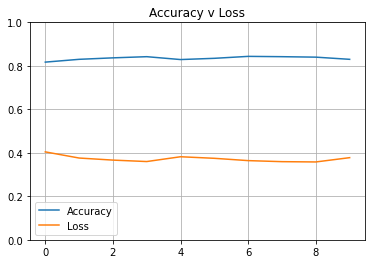

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, train_size=0.7, random_state = 42)
# Printing metrics
print('Final loss and accuracy of Neural Network:', model.evaluate(X_test, y_test))
print('Final predictions of Neural Network: \n', model.predict(X_test), sep='\n')

# Setting up the plot which shows the accuracy and the loss
plt.title("Accuracy v Loss")
plt.plot(pd.DataFrame(history.history).loc[:,["accuracy","loss"]], label='Inline label')
plt.legend(labels=["Accuracy", "Loss"])
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Conclusion

investigated, including tokenization, pos tagging, chunking, lemmatization, stemming, word frequency analysis, term weighting, vectorization, and stopword removal. In order to make processing easier, we started by collecting data from text files and organising it in a data structure. The next step was to remove extraneous punctuation, HTML elements, capital letters, and characters. Then, we lemmatized or applied stemming to our data. The material was subsequently lemmatized since it was more textually relatable. This came at the expense of stemming's computing speed, though. Then, we set up the sentiment column according to the review extraction folders. This allowed us to create a data frame with relevant data for us. 

After the data had been acquired, we began testing a few models with raw text to check their efficiency without any changes to our data. We saw that most of them gave us good accuracy, however, the precision and recal offered from these models were not up to par. Therefore we set up to create a model that would improve on these various metrics.

Given that we already had processed the data, the next step involved the employment of term weighting on our data with the help of TF-IDF vectoriser that was in scikit-learn. We also used ngram_range to perform basic chunking on our text to reduce the feature and improve feature mapping.

Finally we applied this data on a naive bayes model and gained a bump in accuracy by 2% and major bumps in the precision and recall of our model.

Going through this project, we see that a lot of the models can gain relatively good accuracy from raw text, however the precision and recall is not up to par. Therefore, the text processing tasks would help the model to become much better at a general task. 